In [10]:
%matplotlib inline

from pathlib import Path
import time
import traceback
from importlib import reload

import umap
import numpy as np
import scipy.stats as stats
import pandas as pd
pd.set_option('display.max_rows', 50)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', palette='muted')
from matplotlib_venn import venn2, venn3

from TreeMazeAnalyses2.Analyses import subject_info as si

from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from sklearn.covariance import MinCovDet

from matplotlib.patches import Ellipse
import matplotlib.patches as mpatches
import matplotlib.transforms as transforms
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']


In [2]:
%%time
si = reload(si)
subjects = ['Cl']
overwrite = False
for subject in subjects:
    subject_info = si.SubjectInfo(subject, overwrite=overwrite)

CPU times: user 59.4 ms, sys: 15.3 ms, total: 74.6 ms
Wall time: 73.7 ms


In [ ]:
%%time
#subject_info.update_clusters()

### show #s of curated cell/mua on each tt per session

In [3]:
subject_info.sort_tables['curated']

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Cl_T3g_010218,1,2,1,10,0,0,0,1,0,6,0,0,0,0,1,0
Cl_OF_010218,0,4,1,7,0,0,0,0,0,9,0,1,3,0,1,0
Cl_T3g_010318,0,2,2,2,0,0,0,0,0,4,0,0,0,0,1,0
Cl_OF_010318,0,2,6,3,0,0,0,1,0,8,1,2,0,0,0,1
Cl_OF_010418,0,0,9,8,0,0,0,0,0,6,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cl_T3i_021419,0,6,0,14,0,0,0,0,0,2,0,1,0,0,0,0
Cl_T3g_021519,0,3,0,7,0,0,0,0,0,2,0,0,0,0,0,0
Cl_OF_021519,0,5,0,8,0,0,0,0,0,0,0,0,0,0,0,0
Cl_T3i_021519,0,4,0,7,0,0,0,0,0,0,0,0,0,0,0,0


## within session curation validation
1. select sessions if there are 2 or more 2 isolated units
2. load wfs for those units
3. run analyses: tsne and overlap calculations
4. if there are overalping units, merge those clusters

1-2. Get Data

In [3]:
%%time
n_wf = 1000
n_samps = 32*4

session = 'Cl_OF_010218'

session_cell_IDs = subject_info.session_clusters[session]['cell_IDs']

tetrodes_clusters = {}
for tt, clusters in session_cell_IDs.items():
    if len(clusters)>=2:
        tetrodes_clusters[tt] = clusters

for tt, clusters in tetrodes_clusters.items():
# tt =10
# clusters = tetrodes_clusters[tt]
    X = subject_info.get_session_tt_wf(session, tt, cluster_ids=clusters, n_wf=n_wf)
    n_clusters = len(clusters)
    cluster_labels = np.arange(n_clusters).repeat(n_wf)
    break

CPU times: user 17 ms, sys: 491 ms, total: 508 ms
Wall time: 509 ms


In [680]:
tetrodes_clusters

{4: [0, 10, 11, 16], 10: [4, 6, 17]}

In [111]:
%%time
np.random.seed(0)
X_umap=umap.UMAP(random_state=0,n_neighbors=20, n_components=2, min_dist=0).fit_transform(X.reshape(-1, X.shape[-1]))

CPU times: user 18 s, sys: 1.58 s, total: 19.6 s
Wall time: 15.4 s


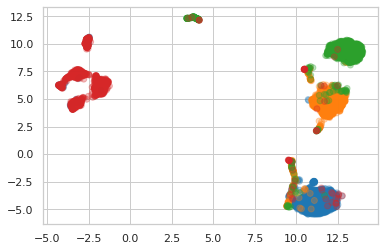

In [113]:
plt.scatter(X_umap[:,0], X_umap[:,1],c=np.array(colors)[cluster_labels], alpha=0.3)

In [115]:
%%time
X_umap=umap.UMAP(random_state=0,n_neighbors=20, n_components=3, min_dist=0).fit_transform(X.reshape(-1, X.shape[-1]))

CPU times: user 18.2 s, sys: 1.38 s, total: 19.6 s
Wall time: 15.8 s


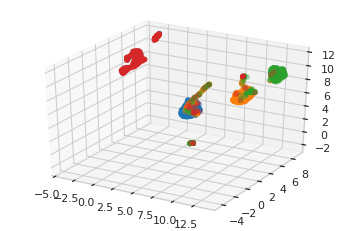

In [121]:
ax = plt.axes(projection='3d') 
ax.scatter3D(X_umap[:,0], X_umap[:,1], X_umap[:,2],c=np.array(colors)[cluster_labels], alpha=0.3)

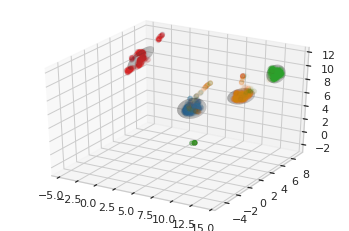

In [190]:
ax=plt.axes(projection='3d')


n_std=3
n_points=250

for kk in range(4):
#     cov = np.cov(X_umap[cluster_labels==kk,:].T)
#     mu = np.mean(X_umap[cluster_labels==kk,:],axis=0)
    mu, cov = estimate_moments(X_umap[cluster_labels==kk,:].T)

    # get eigen values and eigen vectors of covariance
    eig_values, eig_vectors = np.linalg.eig(cov)

    # get radii
    r = n_std*np.sqrt(eig_values)

    # parameterized points
    u = np.linspace(0,2*np.pi,n_points)
    v = np.linspace(0,np.pi,n_points)

    x = r[0]*np.outer(np.cos(u), np.sin(v))
    y = r[1]*np.outer(np.sin(u), np.sin(v))
    z = r[2]*np.outer(np.ones_like(u), np.cos(v))

    for i in range(n_points):
        for j in range(n_points):
            [x[i,j],y[i,j],z[i,j]] = np.dot([x[i,j],y[i,j],z[i,j]], eig_vectors) + mu

    #ax.plot_surface(x,y,z,linewidth=0,antialiased=False, color=colors[kk], alpha=0.1)
    #ax.plot_surface(x,y,z,linewidth=0, color=colors[kk], alpha=0.7)
    ax.plot_surface(x,y,z,linewidth=0, color='grey', alpha=0.2)
    #ax.plot_surface(x,y,z,linewidth=0,antialiased=False, color=colors[5], alpha=0.2)

ax.scatter3D(X_umap[:,0], X_umap[:,1], X_umap[:,2],c=np.array(colors)[cluster_labels], alpha=0.02, zorder=0)
plt.show()

3. Compute. tsne

In [24]:
%%time
np.random.seed(0)
tsne = TSNE(n_jobs=-1, perplexity=20)
X_tsne=tsne.fit_transform(X.reshape(-1, X.shape[-1]))

CPU times: user 2min 2s, sys: 72.8 ms, total: 2min 2s
Wall time: 6.49 s


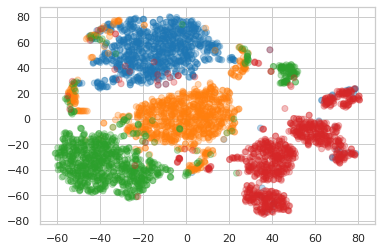

In [25]:
plt.scatter(X_tsne[:,0], X_tsne[:,1],c=np.array(colors)[cluster_labels], alpha=0.3)

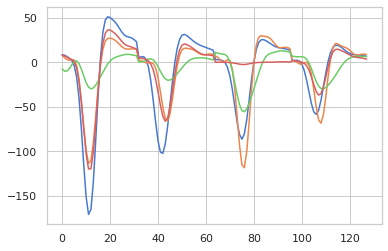

In [8]:
plt.plot(X.mean(axis=1).T)

#### functions to obtain cluster stats

In [119]:
def get_confidence_ellipse_mpl(x, y, mu=None, cov=None, n_std=2):
    if x.size != y.size:
        raise ValueError("x and y must be the same size")
    # ref: https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html

    #cov = np.cov(x, y)
    if (mu is None) and (cov is None):
        mu, cov = estimate_2d_moments(x,y,robust_est=False)    
    
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2)
    
    # calculating the stdandard deviation of y ...
    scale_x = np.sqrt(cov[0, 0]) * n_std
    scale_y = np.sqrt(cov[1, 1]) * n_std

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mu[0],mu[1])

    ellipse.set_transform(transf)
    
    return Polygon(ellipse.properties()['verts'])

def get_2d_confidence_ellipse(x=None, y=None, n_std=2, n_points=100, mu=None, cov=None, robust_est=True):

    # ref: https://cookierobotics.com/007/

    if (mu is None) and (cov is None):
        mu, cov = estimate_2d_moments(x,y,robust_est=False)    
        
    # get eigen values and eigen vectors of covariance
    eig_values, eig_vectors = np.linalg.eig(cov)
    
    # Below we use a parametric formulation for a 2d ellipse 
    
    # parameterized points
    t = np.linspace(0,2*np.pi,n_points)
    v = np.array( [n_std*np.sqrt(eig_values[0])*np.cos(t), 
                   n_std*np.sqrt(eig_values[1])*np.sin(t)] )
    
    # rotation 
    xy = eig_vectors @ v
    
    # translation by coordinate
    xy += mu[:,np.newaxis]
    
    return Polygon(xy.T)

def get_3d_confidence_ellipse(x=None, y=None, z=None, n_std=2, n_points=100, mu=None, cov=None, robust_est=True):

    # ref: https://cookierobotics.com/007/

    if (mu is None) and (cov is None):
        mu, cov = estimate_moments(np.array( (x,y,z)), robust_est=False)    
        
    # get eigen values and eigen vectors of covariance
    eig_values, eig_vectors = np.linalg.eig(cov)
    
    # get radii
    r = n_std*np.sqrt(eig_values)
    
    # parameterized points
    u = np.linspace(0,2*np.pi,n_points)
    v = np.linspace(0,np.pi,n_points)
    
    x = r[0]*np.outer(np.cos(u), np.sin(v))
    y = r[1]*np.outer(np.sin(u), np.sin(v))
    z = r[2]*np.outer(np.ones_like(u), np.cos(v))
    
    xyz = np.array( [n_std*np.sqrt(eig_values[0])*np.cos(t), 
                   n_std*np.sqrt(eig_values[1])*np.sin(t)] )
    
    # rotation 
    xy = eig_vectors @ v
    
    # translation by coordinate
    xy += mu[:,np.newaxis]
    
    return Polygon(xy.T)

def estimate_moments(X, robust_est=True):
    # compute robust covariance: 
    if robust_est:
        fit = MinCovDet(random_state=0).fit(X.T)
        cov = fit.covariance_
        mu =  fit.location_
    else:
        cov = np.cov(X.T)
        mu = np.mean(X,axis=0)
        
    return mu, cov

def kld_mvg(m1, s1, m2, s2):
    
    assert m1.shape==m2.shape, "inputs do not match"
    assert s2.shape==s2.shape, "inputs do not match"
    
    if (m1.ndim==1) & (m2.ndim==1):
        k = len(m1)
        m1 = m1[:,np.newaxis]
        m2 = m2[:,np.newaxis]    
    elif (m1.dim==2) & (m2.ndim==2):
        if (m1.shape[1]>1) or (m2.shape[1]>1):
            print("invalid input")
            return np.nan*np.ones(2)
        k = m1.shape[0]
    else:
        print("invalid input")
        return np.nan*np.ones(2)
    
    inv_s1 = np.linalg.inv(s1)
    inv_s2 = np.linalg.inv(s2)
    
    det_s1 = np.linalg.det(s1)
    det_s2 = np.linalg.det(s2)
    
    kld12 = 0.5 * (np.log(det_s2/det_s1) - k + np.trace(inv_s2@s1) + (m2-m1).T @ inv_s2 @ (m2-m1)) / np.log(2)
    kld21 = 0.5 * (np.log(det_s1/det_s2) - k + np.trace(inv_s1@s2) + (m1-m2).T @ inv_s1 @ (m1-m2)) / np.log(2)
    
    return np.array( [kld12.flatten(), kld21.flatten()])

def entropy_mvg(sigma):
    det = np.linalg.det(sigma)
    k = sigma.shape[0]
    return 0.5*(k + k*np.log(2*np.pi) + np.log(det)) / np.log(2)

def get_clusters_moments(data, cluster_labels, robust_est=True):
    cluster_nums = np.unique(cluster_labels)
    k = data.shape[1]
    mu = np.zeros( (n_clusters, k) )
    cov = np.zeros( (n_clusters, k, k) )
    
    for cluster in cluster_nums:
        X = data[cluster_labels==cluster,:]
        mu[cluster], cov[cluster] = estimate_moments(X, robust_est=robust_est)
    return mu, cov

def get_clusters_dists(clusters_mu, clusters_cov, method='kld', **kwargs):
    if clusters_mu.shape[0] != clusters_cov.shape[0]:
        raise ValueError("number of clusters for moments inputs do not match")
    
    n_clusters = clusters_mu.shape[0]
    dist_mat = np.zeros((n_clusters,n_clusters))
    
    if method == 'pe':
        if ('data' in kwargs.keys()) and ('cluster_labels' in kwargs.keys()):
            for cl1 in range(n_clusters):
                m = clusters_mu[cl1]
                s = clusters_cov[cl1]
                for cl2 in range(n_clusters):
                    x = kwargs['data'][kwargs['cluster_labels']==cl2]
                    dist_mat[cl1, cl2] = mean_samp_prob_gaussian(x, m, s)
        else:
            print(f" cond_prob method needs the data samples and cluster labels")
            return None
    else:
        
        if method == 'kld':
            dist_func = kld_mvg
        elif method == 'hellinger':
            dist_func = hellinger_dist_mvg
            
        for cl1 in range(n_clusters-1):
            m1 = clusters_mu[cl1]
            s1 = clusters_cov[cl1]

            for cl2 in range(cl1, n_clusters):
                m2 = clusters_mu[cl2]
                s2 = clusters_cov[cl2]

                dist_mat[cl1, cl2], dist_mat[cl2, cl1] = dist_func(m1,s1,m2,s2)
    
    return dist_mat

def mean_samp_prob_gaussian(x, m, s):
    #     f = lambda x: np.exp(-1/2*(x-m).T@np.linalg.inv(s)@(x-m))
#     return (np.array([f(x_i) for x_i in x])).mean()
    return stats.multivariate_normal(m, s).pdf(x).mean()
    
def hellinger_dist_1d_gaussians(m1,s1,m2,s2):
    exp_factor = -1/4 * (m1-m2)**2/(s1**2+s**2)
    h2 = 1 - np.sqrt(2*s1*s2/(s1**2+s2**2))*np.exp(exp_factor)
    return np.sqrt(h2)
    
def hellinger_dist_2d_gaussian(m1, s1, m2, s2):
    #https://en.wikipedia.org/wiki/Hellinger_distance
        
    m1 = m1[:,np.newaxis]
    m2 = m2[:,np.newaxis]
    
    s1s2_2 = (s1+s2)/2
    
    det_s1 = np.linalg.det(s1)
    det_s2 = np.linalg.det(s2)
    det_s1s2_2 = np.linalg.det(s1s2_2)
    
    inv_s1s2_2 = np.linalg.inv(s1s2_2)
    
    exp_factor = -1/8*(m1-m2).T @ inv_s1s2_2 @ (m1-m2)
    
    h2 = 1 - (det_s1*det_s2)**(1/4)/(det_s1s2_2)**(1/2) * np.exp(exp_factor)
    h = np.sqrt(h2)

    return np.array([h ,h])

def hellinger_dist_mvg(m1, s1, m2, s2):
    #https://en.wikipedia.org/wiki/Hellinger_distance
        
    assert m1.shape==m2.shape, "inputs do not match"
    assert s2.shape==s2.shape, "inputs do not match"
    
    if (m1.ndim==1) & (m2.ndim==1):
        m1 = m1[:,np.newaxis]
        m2 = m2[:,np.newaxis]    
    elif (m1.dim==2) & (m2.ndim==2):
        if (m1.shape[1]>1) or (m2.shape[1]>1):
            print("invalid input")
            return np.nan*np.ones(2)
    else:
        print("invalid input")
        return np.nan*np.ones(2)
    
    s1s2_2 = (s1+s2)/2
    
    det_s1 = np.linalg.det(s1)
    det_s2 = np.linalg.det(s2)
    det_s1s2_2 = np.linalg.det(s1s2_2)
    
    inv_s1s2_2 = np.linalg.inv(s1s2_2)
    
    exp_factor = -1/8*(m1-m2).T @ inv_s1s2_2 @ (m1-m2)
    
    h2 = 1 - (det_s1*det_s2)**(1/4)/(det_s1s2_2)**(1/2) * np.exp(exp_factor)
    h = np.sqrt(h2)

    return np.array([h ,h])

def get_clusters_entropy(clusters_cov):
    n_clusters = len(clusters_cov)
    
    h = np.zeros(n_clusters)
    for cl in range(n_clusters):
        h[cl] = entropy_mvg(clusters_cov[cl])
        
    return h

def get_all_cluster_dists(clusters_mu, clusters_cov, data, labels):
    n_clusters = len(clusters_mu)
    
    dists_mats =np.zeros((3,n_clusters,n_clusters))
                         
    dists_mats[0] = get_clusters_dists(clusters_mu, clusters_cov, method='hellinger')        
    dists_mats[1] = get_clusters_dists(clusters_mu, clusters_cov, method='kld')
    
    pe = get_clusters_dists(clusters_mu, clusters_cov, method='pe', data=data, cluster_labels=labels)
    dists_mats[2] = np.round(((np.diag(pe)-pe))/np.diag(pe)*1000)/1000
    
    return dists_mats
                         
# def get_joint_

### Estimate mean and covariance & plot confidence ellipsoids1



CPU times: user 56.2 ms, sys: 3.9 ms, total: 60.1 ms
Wall time: 54.2 ms


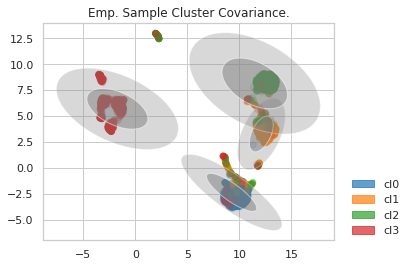

In [29]:
%%time
X_2d = X_umap
clusters_mu, clusters_cov = get_clusters_2d_moments(X_2d, cluster_labels, robust_est=False)

cluster_ellipsoids_2md = []
cluster_ellipsoids_1md = []
for cl in range(n_clusters):
    cluster_ellipsoids_2md.append(get_confidence_ellipse(mu=clusters_mu[cl], cov=clusters_cov[cl], n_std=2))
    cluster_ellipsoids_1md.append(get_confidence_ellipse(mu=clusters_mu[cl], cov=clusters_cov[cl], n_std=1))
    
f, ax = plt.subplots()
label_patch = []
for cl in range(n_clusters):
    #patch = PolygonPatch(cluster_ellipsoids_2md[cl], facecolor=colors[cl], alpha=0.5)
    patch = PolygonPatch(cluster_ellipsoids_2md[cl], facecolor='grey', alpha=0.3)
    ax.add_patch(patch)
    
    patch = PolygonPatch(cluster_ellipsoids_1md[cl], facecolor='grey', alpha=0.5)
    ax.add_patch(patch)
    
    label_patch.append(mpatches.Patch(color=colors[cl], label='cl'+str(cl), alpha=0.7))
    
ax.legend(handles=label_patch, frameon=False, loc=(1.05,0))

ax.scatter(X_2d[:,0], X_2d[:,1],c=np.array(colors)[cluster_labels], alpha=0.2)

ax.set_title("Emp. Sample Cluster Covariance.")
_=ax.axis('scaled')

CPU times: user 1.8 s, sys: 109 µs, total: 1.8 s
Wall time: 1.79 s


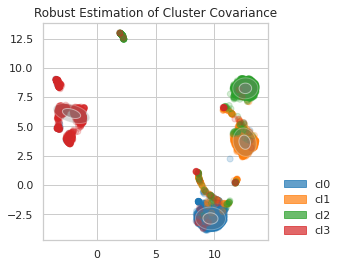

In [30]:
%%time
clusters_mu, clusters_cov = get_clusters_2d_moments(X_2d, cluster_labels, robust_est=True)

cluster_ellipsoids_2md = []
cluster_ellipsoids_1md = []
for cl in range(n_clusters):
    cluster_ellipsoids_2md.append(get_confidence_ellipse(mu=clusters_mu[cl], cov=clusters_cov[cl], n_std=2))
    cluster_ellipsoids_1md.append(get_confidence_ellipse(mu=clusters_mu[cl], cov=clusters_cov[cl], n_std=1))
    
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
label_patch = []
for cl in range(n_clusters):
    #patch = PolygonPatch(cluster_ellipsoids_2md[cl], facecolor=colors[cl], alpha=0.5)
    patch = PolygonPatch(cluster_ellipsoids_2md[cl], facecolor='grey', alpha=0.3)
    ax.add_patch(patch)
    
    patch = PolygonPatch(cluster_ellipsoids_1md[cl], facecolor='grey', alpha=0.5)
    ax.add_patch(patch)
    
    label_patch.append(mpatches.Patch(color=colors[cl], label='cl'+str(cl), alpha=0.7))
    
ax.legend(handles=label_patch, frameon=False, loc=(1.05,0))
    
ax.scatter(X_2d[:,0], X_2d[:,1],c=np.array(colors)[cluster_labels], alpha=0.2)

ax.set_title("Robust Estimation of Cluster Covariance")
_=ax.axis('scaled')

(array([[37.71386275, -5.55439681],
        [-5.55439681, 19.10809453]]),
 array([7.7816505, 3.7019098], dtype=float32))

### get KLD dist matrix & cluster entropy

CPU times: user 2.77 s, sys: 59.9 ms, total: 2.83 s
Wall time: 2.74 s


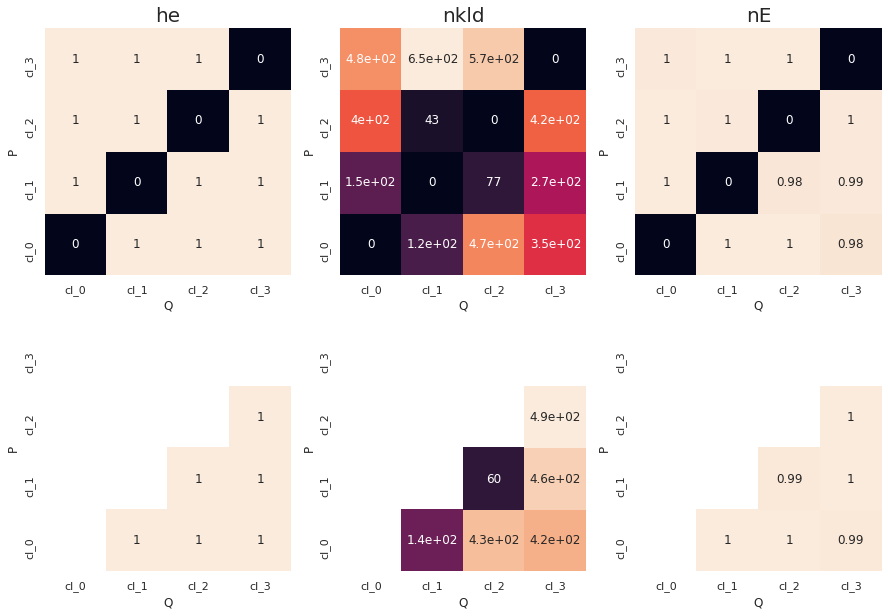

In [120]:
%%time

robust_est=True

if robust_est:
    dist_plot_str = f"clusters_metrics_{session}_{tt}_r.png"
    dist_plot_str2 = f"clusters_metrics_tril_{session}_{tt}_r.png"
else:
    dist_plot_str = f"clusters_metrics_{session}_{tt}.png"
    dist_plot_str2 = f"clusters_metrics_tril_{session}_{tt}.png"

clusters_mu, clusters_cov = get_clusters_2d_moments(X_2d, cluster_labels, robust_est=robust_est)

dists_mats = get_all_cluster_dists(clusters_mu, clusters_cov, data=X_2d, labels=cluster_labels)

metrics = {'he':dists_mats[0], 'nkld':dists_mats[1], 'nE':dists_mats[2]}
labels = ['cl_'+str(ii) for ii in range(4)]

f, ax = plt.subplots(2,3,figsize=(15,10))
for ii, metric in enumerate(metrics.keys()):
    sns.heatmap(metrics[metric], xticklabels=labels, yticklabels=labels, annot=True, ax=ax[0,ii], cbar=False, robust=True)
    ax[0,ii].invert_yaxis()
    ax[0,ii].set_title(metric,fontsize=20)
    ax[0,ii].set_xlabel("Q")
    ax[0,ii].set_ylabel("P")


mask = np.zeros_like(dists_mats[0])
mask[np.tril_indices_from(mask)] = True
for ii, metric in enumerate(metrics.keys()):
    mat = 0.5*(metrics[metric]+metrics[metric].T)
    sns.heatmap(mat, mask=mask, xticklabels=labels, yticklabels=labels, annot=True, ax=ax[1,ii], cbar=False, vmin=0)
    ax[1,ii].invert_yaxis()
    ax[1,ii].set_xlabel("Q")
    ax[1,ii].set_ylabel("P")

fig_path = Path('/home/alexgonzalez/Documents/treemazefigs/misc_figs/')
f.savefig(fig_path/dist_plot_str, bbox_inches='tight')


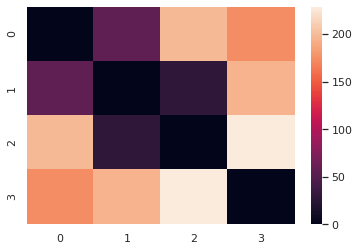

In [100]:
a = 0.5*(dists_mats+np.moveaxis(dists_mats,2,1))
sns.heatmap(a[1], vmin=0)

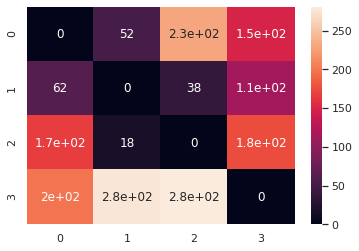

In [101]:
sns.heatmap(dists_mats[1],annot=True)

-0.02108329874921752

In [86]:
cl1,cl2 = 1,2
m1, m2 = clusters_mu[cl1], clusters_mu[cl2]
s1, s2 = clusters_cov[cl1], clusters_cov[cl2]

s2, np.linalg.det(s2), entropy_2d_gaussian(s2), kld_2d_gaussian(m1,s1,m2,s2)

(array([[0.28616658, 0.00241235],
        [0.00241235, 0.19872741]]),
 0.05686332346064418,
 -0.02108329874921752,
 array([[76.76086888],
        [42.50369262]]))

In [89]:
kld_2d_gaussian(m1,s1,m2,s2)/entropy_2d_gaussian(s2)


array([[-3640.83769762],
       [-2015.98872787]])

### Toy example with dummy data

hellinger
[[0.    0.718 0.388 0.987]
 [0.718 0.    0.923 0.999]
 [0.388 0.923 0.    0.996]
 [0.987 0.999 0.996 0.   ]]

nkld
[[ 0.     3.035  0.657 13.722]
 [ 1.038  0.     5.374 19.494]
 [ 0.239  5.374  0.    12.827]
 [ 6.078 20.539 16.399  0.   ]]

npe
[[ 0.     0.83   0.456  0.999]
 [ 0.662  0.     0.978  1.   ]
 [-0.083  0.982  0.     1.   ]
 [ 0.999  1.     1.     0.   ]]



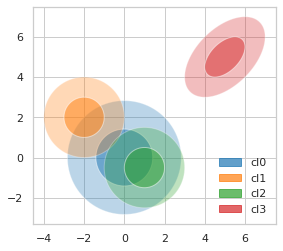

In [634]:
np.random.seed(0)
clusters_mu_dummy = [np.array([0,0]),np.array([-2,2]), np.array([1,-0.5]), np.array([5,5])]
clusters_cov_dummy = [2*np.eye(2)]+[np.eye(2)]*2+[np.array( ([1,0.5],[0.5,1]) )]

n_clusters_dummy = len(clusters_mu_dummy)

n_dummy_dat = 1000
dummy_labels = np.arange(n_clusters_dummy).repeat(n_dummy_dat)
dummy_data = np.zeros((len(dummy_labels),2))
for cl in range(n_clusters_dummy):
    dummy_data[dummy_labels==cl]=stats.multivariate_normal(clusters_mu_dummy[cl], clusters_cov_dummy[cl]).rvs(n_dummy_dat)
    
pe = get_clusters_dists(clusters_mu_dummy, clusters_cov_dummy, method='pe', data=dummy_data, cluster_labels=dummy_labels)
nkld = get_clusters_dists(clusters_mu_dummy, clusters_cov_dummy, method='kld') / get_clusters_entropy(clusters_cov_dummy)
he = kld = get_clusters_dists(clusters_mu_dummy, clusters_cov_dummy, method='hellinger')
npe = (np.diag(pe)-pe)/np.diag(pe)

print("hellinger")
print(np.around(he,3))
print()

print('nkld')
print(np.around(nkld,3))
print()

print('npe')
print(np.around(npe,3))
print()

cluster_ellipsoids_2md = []
cluster_ellipsoids_1md = []
for cl in range(len(clusters_mu_dummy)):
    
    
    cluster_ellipsoids_2md.append(get_confidence_ellipse(mu=clusters_mu_dummy[cl], cov=clusters_cov_dummy[cl], n_std=2))
    cluster_ellipsoids_1md.append(get_confidence_ellipse(mu=clusters_mu_dummy[cl], cov=clusters_cov_dummy[cl], n_std=1))
    
f, ax = plt.subplots()
label_patch = []
for cl in range(len(clusters_mu_dummy)):
    #patch = PolygonPatch(cluster_ellipsoids_2md[cl], facecolor=colors[cl], alpha=0.5)
    patch = PolygonPatch(cluster_ellipsoids_2md[cl], facecolor=colors[cl], alpha=0.3)
    ax.add_patch(patch)
    
    patch = PolygonPatch(cluster_ellipsoids_1md[cl], facecolor=colors[cl], alpha=0.5)
    ax.add_patch(patch)
    
    label_patch.append(mpatches.Patch(color=colors[cl], label='cl'+str(cl), alpha=0.7))
    
_=ax.axis('scaled')
ax.legend(handles=label_patch, frameon=False)

In [635]:
fig_path = Path('/home/alexgonzalez/Documents/treemazefigs/misc_figs/')
f.savefig(fig_path/'toy_clusters.png', bbox_inches='tight')

In [676]:
def get_all_cluster_dists(clusters_mu, clusters_cov, data, labels):
    n_clusters = len(clusters_mu)
    
    dists_mats =np.zeros((3,n_clusters,n_clusters))
                         
    dists_mats[0] = get_clusters_dists(clusters_mu_dummy, clusters_cov_dummy, method='hellinger')        
    dists_mats[1] = get_clusters_dists(clusters_mu_dummy, clusters_cov_dummy, method='kld') / get_clusters_entropy(clusters_cov_dummy)
    
    pe = get_clusters_dists(clusters_mu_dummy, clusters_cov_dummy, method='pe', data=dummy_data, cluster_labels=dummy_labels)
    dists_mats[2] = np.round(((np.diag(pe)-pe))/np.diag(pe)*1000)/1000
    
    return dists_mats
                         
dists_mats = get_all_cluster_dists(clusters_mu_dummy, clusters_cov_dummy, data=dummy_data, labels=dummy_labels)

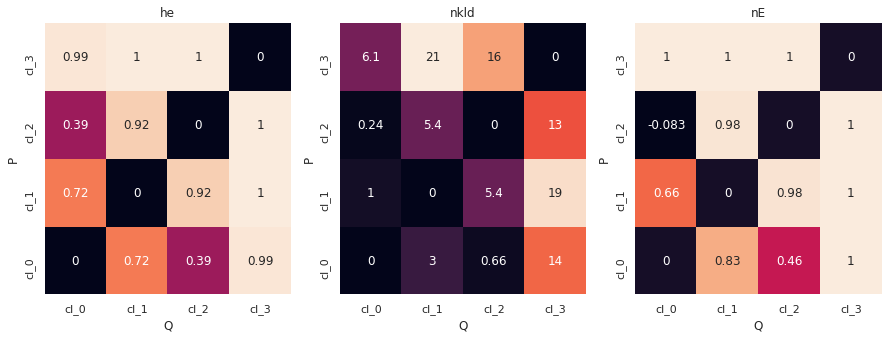

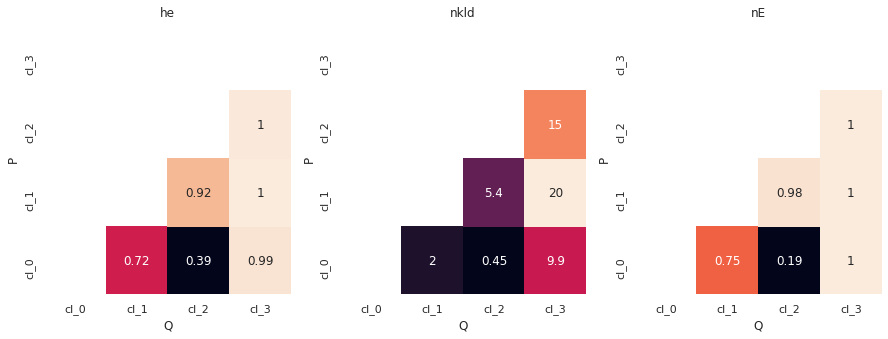

In [707]:
dists_mats = get_all_cluster_dists(clusters_mu_dummy, clusters_cov_dummy, data=dummy_data, labels=dummy_labels)

metrics = {'he':dists_mats[0], 'nkld':dists_mats[1], 'nE':dists_mats[2]}
labels = ['cl_'+str(ii) for ii in range(4)]

f, ax = plt.subplots(1,3,figsize=(15,5))
for ii, metric in enumerate(metrics.keys()):
    sns.heatmap(metrics[metric], xticklabels=labels, yticklabels=labels, annot=True, ax=ax[ii], cbar=False, robust=True)
    ax[ii].invert_yaxis()
    ax[ii].set_title(metric)
    ax[ii].set_xlabel("Q")
    ax[ii].set_ylabel("P")

fig_path = Path('/home/alexgonzalez/Documents/treemazefigs/misc_figs/')
f.savefig(fig_path/'toy_clusters_metrics.png', bbox_inches='tight')

f, ax = plt.subplots(1,3,figsize=(15,5))

mask = np.zeros_like(dists_mats[0])
mask[np.tril_indices_from(mask)] = True
for ii, metric in enumerate(metrics.keys()):
    mat = 0.5*(metrics[metric]+metrics[metric].T)
    sns.heatmap(mat, mask=mask, xticklabels=labels, yticklabels=labels, annot=True, ax=ax[ii], cbar=False, robust=True)
    ax[ii].invert_yaxis()
    ax[ii].set_title(metric)
    ax[ii].set_xlabel("Q")
    ax[ii].set_ylabel("P")

fig_path = Path('/home/alexgonzalez/Documents/treemazefigs/misc_figs/')
f.savefig(fig_path/'toy_clusters_metrics_tril.png', bbox_inches='tight')

## see sessions that are matched for depth for a given tetrode

In [4]:
tt = 4
depth = 14.25
subject_info.tt_depth_match[tt][depth]

['Cl_T3g_010218',
 'Cl_OF_010218',
 'Cl_T3g_010318',
 'Cl_OF_010318',
 'Cl_OF_010418',
 'Cl_T3g_010418',
 'Cl_T3g_123118',
 'Cl_OF_123118',
 'Cl_T3g_010619',
 'Cl_OF_010619',
 'Cl_T3g_010719',
 'Cl_OF_010719']

In [710]:
subject_info.tt_depth_match[4][12.25]

['Cl_T3g_112318', 'Cl_OF_112318', 'Cl_T3g_112818', 'Cl_OF_112818']

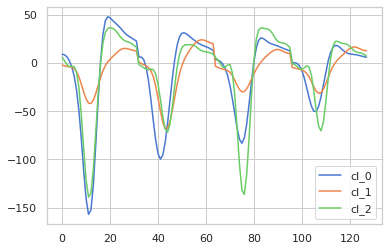

In [194]:
tt=4
session = 'Cl_T3g_010218'
cluster_ids = subject_info.session_clusters[session]['cell_IDs'][tt]
a=subject_info.get_session_tt_wf(session,4, cluster_ids=cluster_ids)
_=plt.plot(a.mean(axis=1).T)
plt.legend(['cl_'+str(ii) for ii in range(3)])


### select cluster match analyses based on isolated cells

In [466]:
%%time
analyses = []
for tt in np.arange(1,17):
    tt_depths = list(subject_info.tt_depth_match[tt].keys())
    for tt_d in tt_depths:
        tt_d_sessions = subject_info.tt_depth_match[tt][tt_d]
        # check if there are more 2 or more sessions with units
        n_cells_session = np.zeros(len(tt_d_sessions),dtype=int)
        for ii, session in enumerate(tt_d_sessions):
            session_cell_IDs = subject_info.session_clusters[session]['cell_IDs']
            if tt in session_cell_IDs.keys():
                n_cells_session[ii] = len(session_cell_IDs[tt])
        sessions_with_cells = np.where(n_cells_session>0)[0]
        if len(sessions_with_cells)>=2:
            analyses.append( (tt, 
                              tt_d, 
                              np.array(tt_d_sessions)[sessions_with_cells].tolist(), 
                              n_cells_session[sessions_with_cells].tolist())
                           )


CPU times: user 8.57 ms, sys: 11 µs, total: 8.58 ms
Wall time: 8.24 ms


In [715]:
analyses[12]

(4, 12.0, ['Cl_T3g_112118_0001', 'Cl_OF_112118'], [1, 4])

In [729]:
n_wf = 1000
n_samps = 32*4
analyses_id = 12
tt, d, sessions, n_session_units = analyses[analyses_id]

X = np.empty((0,n_wf,n_samps),dtype=np.float16)
for session in sessions:
    cluster_ids = subject_info.session_clusters[session]['cell_IDs'][tt]
    session_cell_wf = subject_info.get_session_tt_wf(session, tt, cluster_ids=cluster_ids, n_wf=n_wf)
    X = np.concatenate((X,session_cell_wf),axis=0)

n_clusters = np.array(n_session_units).sum()
cluster_labels = np.arange(n_clusters).repeat(n_wf)
for session_idx, n_session_clusters in enumerate(n_session_units):
    if session_idx==0:
        session_labels = np.zeros(n_session_clusters*n_wf, dtype=int)
    else:
        session_labels = np.concatenate( (session_labels, session_idx*np.ones(n_session_clusters*n_wf )) ).astype(int)

session_clusters_id = [[ii]*session_units for ii,session_units in enumerate(n_session_units)]
session_clusters_id = [item for sublist in session_clusters_id for item in sublist]

In [730]:
print(f' n sessions {len(sessions)} \n n clusters {n_clusters} \n Data Shape {X.shape} \n Clusters Shape {cluster_labels.shape} \n Session Shape {session_labels.shape}') 

 n sessions 2 
 n clusters 5 
 Data Shape (5, 1000, 128) 
 Clusters Shape (5000,) 
 Session Shape (5000,)


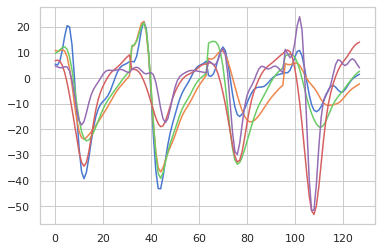

In [746]:
plt.plot(X.mean(axis=1).T)

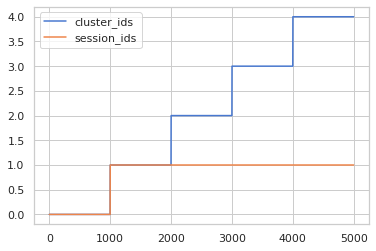

In [719]:
plt.plot(cluster_labels, label = 'cluster_ids')
plt.plot(session_labels, label = 'session_ids')
plt.legend()

## Apply tsne to the waveforms

In [731]:
%%time
tsne = TSNE(n_jobs=-1, perplexity=20)
X_tsne=tsne.fit_transform(X.reshape(-1, X.shape[-1]))
print(f' TSNE Data Shape {X_tsne.shape}')

 TSNE Data Shape (5000, 2)
CPU times: user 3min 25s, sys: 2.68 s, total: 3min 27s
Wall time: 11 s


CPU times: user 2.71 s, sys: 0 ns, total: 2.71 s
Wall time: 2.71 s


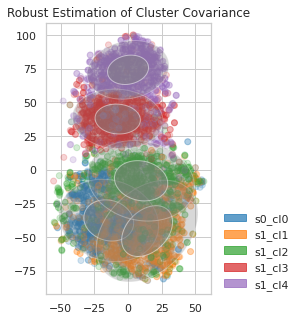

In [741]:
%%time
clusters_mu, clusters_cov = get_clusters_2d_moments(X_tsne, cluster_labels, robust_est=True)

cluster_ellipsoids_2md = []
cluster_ellipsoids_1md = []
for cl in range(n_clusters):
    cluster_ellipsoids_2md.append(get_confidence_ellipse(mu=clusters_mu[cl], cov=clusters_cov[cl], n_std=2))
    cluster_ellipsoids_1md.append(get_confidence_ellipse(mu=clusters_mu[cl], cov=clusters_cov[cl], n_std=1))
    
f, ax = plt.subplots(figsize=(6,5))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
label_patch = []
for cl in range(n_clusters):
    #patch = PolygonPatch(cluster_ellipsoids_2md[cl], facecolor=colors[cl], alpha=0.5)
    patch = PolygonPatch(cluster_ellipsoids_2md[cl], facecolor='grey', alpha=0.3)
    ax.add_patch(patch)
    
    patch = PolygonPatch(cluster_ellipsoids_1md[cl], facecolor='grey', alpha=0.5)
    ax.add_patch(patch)
    
    label_patch.append(mpatches.Patch(color=colors[cl], label='s'+str(session_clusters_id[cl])+'_cl'+str(cl), alpha=0.7))
    
ax.legend(handles=label_patch, frameon=False, loc=(1.05,0))
    
ax.scatter(X_tsne[:,0], X_tsne[:,1],c=np.array(colors)[cluster_labels], alpha=0.2)

ax.set_title("Robust Estimation of Cluster Covariance")
_=ax.axis('scaled')

In [742]:
fig_path = Path('/home/alexgonzalez/Documents/treemazefigs/misc_figs/')
f.savefig(fig_path/f"cluster_sesssion_match_{subject}_{analyses_id}.png", bbox_inches='tight')

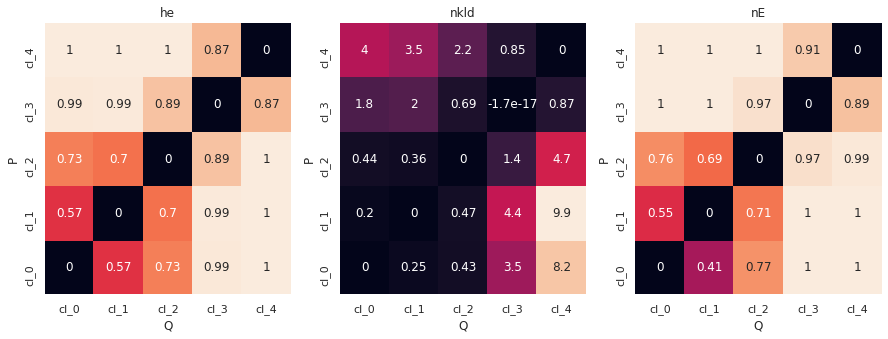

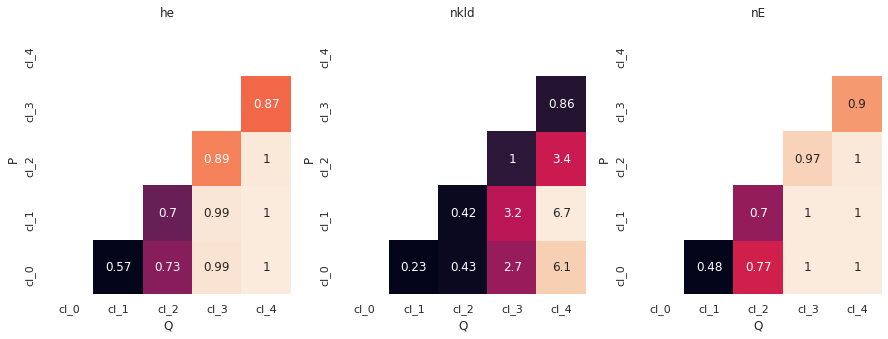

In [747]:
robust_est=True

if robust_est:
    dist_plot_str = f"clusters_metrics_{subject}_{analyses_id}_r.png"
    dist_plot_str2 = f"clusters_metrics_tril_{subject}_{analyses_id}_r.png"
else:
    dist_plot_str = f"clusters_metrics_{subject}_{analyses_id}.png"
    dist_plot_str2 = f"clusters_metrics_tril_{subject}_{analyses_id}.png"

clusters_mu, clusters_cov = get_clusters_2d_moments(X_tsne, cluster_labels, robust_est=robust_est)

dists_mats = get_all_cluster_dists(clusters_mu, clusters_cov, data=X_tsne, labels=cluster_labels)

metrics = {'he':dists_mats[0], 'nkld':dists_mats[1], 'nE':dists_mats[2]}
labels = ['cl_'+str(ii) for ii in range(len(clusters_mu))]

f, ax = plt.subplots(1,3,figsize=(15,5))
for ii, metric in enumerate(metrics.keys()):
    sns.heatmap(metrics[metric], xticklabels=labels, yticklabels=labels, annot=True, ax=ax[ii], cbar=False, robust=True)
    ax[ii].invert_yaxis()
    ax[ii].set_title(metric)
    ax[ii].set_xlabel("Q")
    ax[ii].set_ylabel("P")

fig_path = Path('/home/alexgonzalez/Documents/treemazefigs/misc_figs/')
f.savefig(fig_path/dist_plot_str, bbox_inches='tight')

f, ax = plt.subplots(1,3,figsize=(15,5))
mask = np.zeros_like(dists_mats[0])
mask[np.tril_indices_from(mask)] = True
for ii, metric in enumerate(metrics.keys()):
    mat = 0.5*(metrics[metric]+metrics[metric].T)
    sns.heatmap(mat, mask=mask, xticklabels=labels, yticklabels=labels, annot=True, ax=ax[ii], cbar=False, robust=True)
    ax[ii].invert_yaxis()
    ax[ii].set_title(metric)
    ax[ii].set_xlabel("Q")
    ax[ii].set_ylabel("P")

fig_path = Path('/home/alexgonzalez/Documents/treemazefigs/misc_figs/')
f.savefig(fig_path/dist_plot_str2, bbox_inches='tight')

In [745]:
X.shape

(5, 1000, 128)

In [727]:
%%time
X_pca = PCA(n_components=2).fit_transform(X)

CPU times: user 284 ms, sys: 4.89 ms, total: 289 ms
Wall time: 38 ms


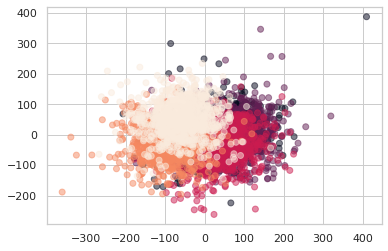

In [728]:
plt.scatter(X_pca[:,0], X_pca[:,1],c=cluster_labels, alpha=0.5)

In [760]:
import umap
umap = reload(umap)

ImportError: cannot import name 'cffi_utils' from 'numba.typing' (/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/numba/typing/__init__.py)

In [755]:
mapper = umap.UMAP(random_state=0).fit(X.reshape(-1, X.shape[-1]))

AttributeError: module 'umap' has no attribute 'UMAP'

In [757]:
umap.__dict__

{'__name__': 'umap',
 '__doc__': None,
 '__package__': 'umap',
 '__loader__': <_frozen_importlib_external.SourceFileLoader at 0x7f9c49c6c470>,
 '__spec__': ModuleSpec(name='umap', loader=<_frozen_importlib_external.SourceFileLoader object at 0x7f9c49c6c470>, origin='/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/umap/__init__.py', submodule_search_locations=['/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/umap']),
 '__path__': ['/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/umap'],
 '__file__': '/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/umap/__init__.py',
 '__cached__': '/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/umap/__pycache__/__init__.cpython-37.pyc',
 '__builtins__': {'__name__': 'builtins',
  '__doc__': "Built-in functions, exceptions, and other objects.\n\nNoteworthy: None is the `nil' object; Ellipsis represents `...' in slices.",
  '__package__': ''

## create confidence ellipsoids around tsne clusters

In [171]:
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    ax.add_patch(ellipse)
    return ax, ellipse

In [ ]:
def get_confidence_ellipse(x, y, n_std=2):
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2)
    
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf)
    
    return Polygon(ellipse.properties()['verts']
    

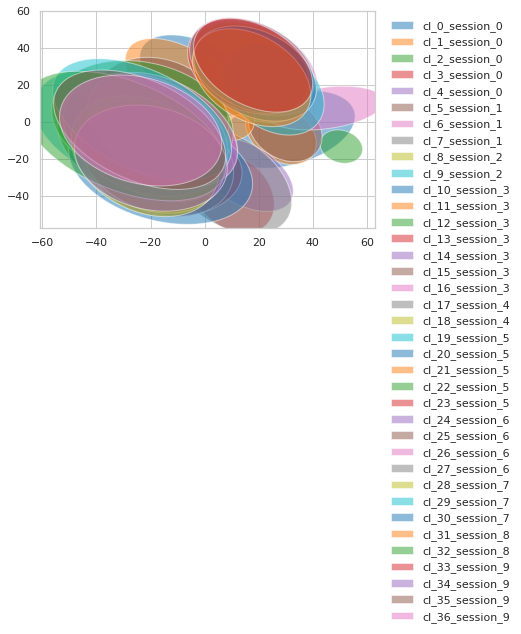

In [207]:
f,ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
polys = []
for cluster in range(n_clusters):
    x = X_tsne[cluster_labels==cluster,0]
    y = X_tsne[cluster_labels==cluster,1]

    label_str = f'cl_{cluster}_session_{session_clusters_id[cluster]}'
    #ax.scatter(x,y, color=colors[cluster], alpha=0.1)
    ax, ellipse = confidence_ellipse(x, y, ax=ax, facecolor=colors[np.mod(cluster,10)], alpha=0.5, n_std=2, label=label_str)
    polys.append(Polygon(ellipse.properties()['verts']))
ax.set_xlim(np.array([X_tsne[:,0].min(),X_tsne[:,0].max()])*1.1 )
ax.set_ylim(np.array([X_tsne[:,1].min(),X_tsne[:,1].max()])*1.1 )
ax.legend(bbox_to_anchor=(1.02, 1), frameon=False)

## asymetrical overlap between ellipsoids

In [209]:
pct_overlap = np.zeros((n_clusters,n_clusters))

for cluster1 in range(n_clusters):
    poly1 = polys[cluster1]
    area_cl1 = poly1.area
    for cluster2 in range(n_clusters):
        pct_overlap[cluster1,cluster2] = poly1.intersection(polys[cluster2]).area/area_cl1
        

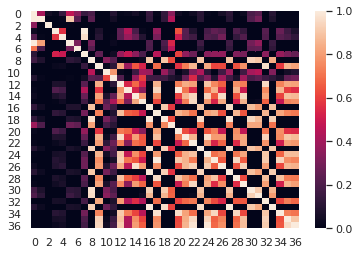

In [210]:
sns.heatmap(pct_overlap)

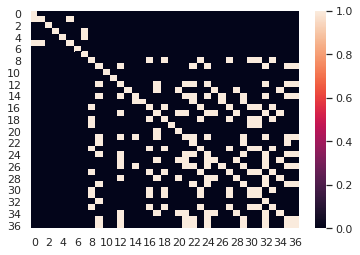

In [211]:
sns.heatmap(pct_overlap>0.8)

## symetrical overlap

In [212]:
pct_overlap2 = np.zeros((n_clusters,n_clusters))

for cluster1 in range(n_clusters):
    poly1 = polys[cluster1]
    area_cl1 = poly1.area
    for cluster2 in range(n_clusters):
        poly2 = polys[cluster2]
        area_cl2 = poly2.area
        pct_overlap[cluster1,cluster2] = 2*poly1.intersection(poly2).area/(area_cl1+area_cl2)

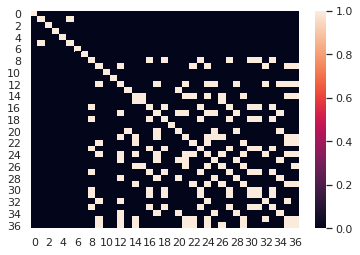

In [213]:
sns.heatmap(pct_overlap>0.8)

10

In [178]:
mwf = X.reshape(n_units,1000,128).mean(axis=1)

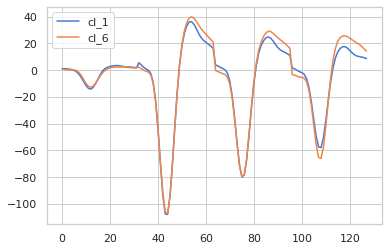

In [195]:
selected_cl = [1,6] 
plt.plot(mwf[selected_cl,:].T)
plt.legend(['cl_'+str(ii) for ii in selected_cl])

In [63]:
n_x_bins = 100
n_y_bins = 100
x_min, x_max = X_tsne[:,0].min(), X_tsne[:,0].max()
y_min, y_max = X_tsne[:,1].min(), X_tsne[:,1].max()
x_bin_edges = np.linspace(x_min*1.01,x_max*1.01, n_x_bins+1)
y_bin_edges = np.linspace(y_min*1.01,y_max*1.01, n_y_bins+1)

X_cluster_images = np.zeros((n_clusters, n_y_bins, n_x_bins))
for cluster in range(n_clusters):
    x = X_tsne[cluster_labels==cluster,0]
    y = X_tsne[cluster_labels==cluster,1]
    X_cluster_images[cluster], _, _ = np.histogram2d(y,x, bins=np.array( (y_bin_edges,x_bin_edges )))

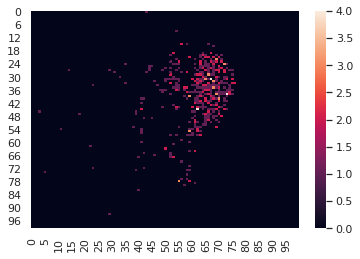

In [72]:
sns.heatmap(X_cluster_images[4])

In [53]:
x=np.arange(100).reshape(4,-1)
spk_times = np.arange(6,25,5)
wf_samps = np.arange(-2,2)
print(x)
print(spk_times)
#print(x[:,])

[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24]
 [25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
  49]
 [50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
  74]
 [75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98
  99]]
[ 6 11 16 21]


In [16]:
#np.array(list(subject_info.session_clusters[session]['cell_IDs'].keys()))-1
subject_info.session_clusters[session]['cell_IDs'].values()

dict_values([[], [1, 15], [4, 9, 18], [], [], [], [], [], [], [], [], [], [], []])

In [16]:
a=subject_info._sort_tables()

ValueError: shape mismatch: value array of shape (15,) could not be broadcast to indexing result of shape (13,)

In [ ]:
subject_info._get_clusters(True)
subject_info._get_sort_tables()

In [18]:
subject_info.session_clusters['Cl_OF_010218']['mua_IDs']

{'1': [],
 '2': [0, 3, 4, 14],
 '3': [],
 '4': [1, 9, 12],
 '5': [],
 '6': [],
 '7': [],
 '8': [],
 '9': [],
 '10': [5, 7, 9, 12, 15, 16],
 '11': [],
 '12': [8],
 '13': [2, 6, 15],
 '14': [],
 '15': [4]}

In [12]:
subject_info.tetrodes

/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [42]:
x=np.fromfile(subject_info.session_paths['Cl_T3g_010218']['Sorted']/'tt_4/KS2/recording.dat', dtype=np.float16)

In [36]:
o=np.load(subject_info.session_paths['Cl_T3g_010218']['PreProcessed']/'tt_4.npy')

In [54]:
xx=x.reshape(-1,4)

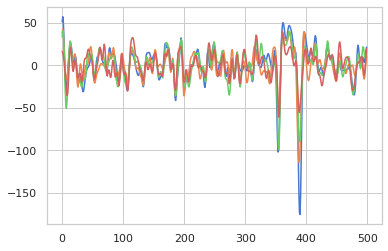

In [57]:
i=100
wl = 500
w = np.arange(wl)+ i*wl
plt.plot(xx[w,:])

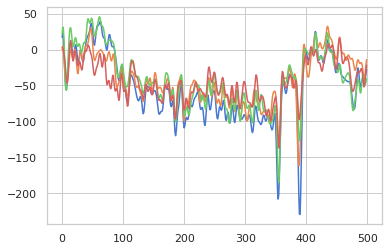

In [58]:
plt.plot(o[:,w].T)

In [8]:
spike_times=np.load(subject_info.session_paths['Cl_T3g_010218']['Sorted']/'tt_4/KS2/spike_times.npy')
spike_clusters=np.load(subject_info.session_paths['Cl_T3g_010218']['Sorted']/'tt_4/KS2/spike_clusters.npy')


In [15]:
spike_times[spike_clusters==1].flatten()

array([    13868,     21868,     30522, ..., 129957736, 129963708,
       129975802], dtype=uint32)

In [72]:
isinstance(spike_times, np.narray)

True

In [200]:
cluster_groups = pd.read_csv(subject_info.session_paths['Cl_T3g_010218']['Sorted']/'tt_4/KS2/cluster_group.tsv', sep='\t')

In [207]:
valid_units = cluster_groups.group.isin(['good','mua'])
cluster_groups.cluster_id[valid_units].values

array([ 0,  2,  3,  4,  8, 11, 14, 16, 17, 18])

In [205]:
cluster_groups

,cluster_id,group
0,0,good
1,1,noise
2,2,mua
3,3,good
4,4,mua
5,5,noise
6,8,mua
7,11,mua
8,12,noise
9,14,mua


In [154]:
# p = Path('/home/alexgonzalez/Documents/data/ag_rat_metadata/Tetrodes.xlsx')
# tt_pos = pd.read_excel(p.open(mode='rb'), sheet_name=subject, engine='openpyxl')
# tt_pos['Date'] = [date.strftime('%m%d%y') if not pd.isnull(date) else '' for date in tt_pos['Date']]
# tt_pos = tt_pos[tt_pos['Date']!='']
# tt_pos = tt_pos.set_index('Date')

p = Path(subject_info.results_path.parent / 'Cl_tetrodes.csv')
tt_pos = pd.read_csv(p)

tt_pos['Date'] = pd.to_datetime(tt_pos['Date']).dt.strftime('%m%d%y')
tt_pos = tt_pos.set_index('Date')

tt_pos=tt_pos[ ['TT'+str(tt)+'_overall' for tt in range(1,17)]] 

In [155]:
tt_pos

,TT1_overall,TT2_overall,TT3_overall,TT4_overall,TT5_overall,TT6_overall,TT7_overall,TT8_overall,TT9_overall,TT10_overall,TT11_overall,TT12_overall,TT13_overall,TT14_overall,TT15_overall,TT16_overall
Date,,,,,,,,,,,,,,,,
112118,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00
112218,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00
112318,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25
112418,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25
112518,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
021319,17.50,17.00,17.25,16.50,17.50,17.00,17.50,17.00,17.25,16.25,17.25,17.00,17.50,17.50,17.00,17.25
021419,17.75,17.25,17.50,16.75,17.75,17.25,17.75,17.25,17.50,16.50,17.50,17.25,17.75,17.75,17.25,17.50
021519,17.75,17.25,17.50,16.75,17.75,17.25,17.75,17.25,17.50,16.50,17.50,17.25,17.75,17.75,17.25,17.50


In [83]:
session_dates

{'Cl_T3g_010218': '010218',
 'Cl_OF_010218': '010218',
 'Cl_T3g_010318': '010318',
 'Cl_OF_010318': '010318',
 'Cl_OF_010418': '010418',
 'Cl_T3g_010418': '010418',
 'Cl_T3g_112118': '112118',
 'Cl_T3g_112118_0001': '112118',
 'Cl_OF_112118': '112118',
 'Cl_T3g_112318': '112318',
 'Cl_OF_112318': '112318',
 'Cl_T3g_112818': '112818',
 'Cl_OF_112818': '112818',
 'Cl_OF_112918': '112918',
 'Cl_T3g_112918': '112918',
 'Cl_T3g_113018': '113018',
 'Cl_OF_113018': '113018',
 'Cl_T3g_120118': '120118',
 'Cl_T3g_120118_0001': '120118',
 'Cl_T3g_120118_0': '120118',
 'Cl_OF_120118': '120118',
 'Cl_T3g_120318': '120318',
 'Cl_OF_120318': '120318',
 'Cl_OF_120418': '120418',
 'Cl_T3g_120418': '120418',
 'Cl_OF_120518': '120518',
 'Cl_T3g_120518': '120518',
 'Cl_OF_120618': '120618',
 'Cl_T3g_120618': '120618',
 'Cl_T3g_120718': '120718',
 'Cl_OF_120718': '120718',
 'Cl_OF_120918': '120918',
 'Cl_T3g_120918': '120918',
 'Cl_OF_121018': '121018',
 'Cl_T3g_121018': '121018',
 'Cl_T3g_121118': '12111

In [156]:
session_dates = {session:session.split('_')[2] for session in subject_info.sessions}
session_tt = pd.DataFrame(index = subject_info.sessions, columns = ['tt_' + str(tt) for tt in range(1,17)])

for session in subject_info.sessions:
    date = session_dates[session]
    if date in ['010218','010318','010418']:
        date = date[:5] + '9'
    session_tt.loc[session] = tt_pos.loc[date].values
    

/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [161]:
session_tt.iloc[:10]

,tt_1,tt_2,tt_3,tt_4,tt_5,tt_6,tt_7,tt_8,tt_9,tt_10,tt_11,tt_12,tt_13,tt_14,tt_15,tt_16
Cl_T3g_010218,14.75,14.25,14.5,14.25,14.75,14.5,14.75,14.5,14.75,13.75,14.5,14.25,14.75,14.75,14.5,14.5
Cl_OF_010218,14.75,14.25,14.5,14.25,14.75,14.5,14.75,14.5,14.75,13.75,14.5,14.25,14.75,14.75,14.5,14.5
Cl_T3g_010318,14.75,14.25,14.5,14.25,14.75,14.5,14.75,14.5,14.75,13.75,14.5,14.25,14.75,14.75,14.5,14.5
Cl_OF_010318,14.75,14.25,14.5,14.25,14.75,14.5,14.75,14.5,14.75,13.75,14.5,14.25,14.75,14.75,14.5,14.5
Cl_OF_010418,15,14.5,14.75,14.25,15,14.75,15,14.75,15,13.75,14.75,14.5,15,15,14.75,14.75
Cl_T3g_010418,15,14.5,14.75,14.25,15,14.75,15,14.75,15,13.75,14.75,14.5,15,15,14.75,14.75
Cl_T3g_112118,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12
Cl_T3g_112118_0001,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12
Cl_OF_112118,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12
Cl_T3g_112318,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25


In [173]:
n_tt = 16
tetrodes = range(1,n_tt+1)
tt_depth_matchs = {tt:{} for tt in tetrodes}

for tt in tetrodes:
    tt_str = 'tt_'+str(tt)
    tt_depths = session_tt[tt_str].unique()
    for depth in tt_depths:
        tt_depth_matchs[tt][depth] = list(session_tt[session_tt[tt_str]==depth].index)
        

In [11]:

np.sum([len(v) for k,v in subject_info.session_clusters['Cl_T3g_010218']['cell_IDs'].items()])
np.sum([len(v) for k,v in subject_info.session_clusters['Cl_T3g_010218']['mua_IDs'].items()])


15

In [16]:
a=np.array([len(v) for k,v in subject_info.session_clusters['Cl_T3g_010218']['cell_IDs'].items()])

b=np.array([len(v) for k,v in subject_info.session_clusters['Cl_T3g_010218']['mua_IDs'].items()])


In [19]:
subject_info.session_clusters['Cl_T3g_010218']['curated_TTs']

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 15]